<a href="https://colab.research.google.com/github/Ritishh00/GEN-AI/blob/main/GEN_AI_29_01_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import datasets
from tensorflow.keras.losses import MeanSquaredError , KLDivergence , BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
# Import ModelCheckpoint and EarlyStopping from tensorflow.keras.callbacks instead of tensorflow.keras.optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from numpy import cov, trace, iscomplexobj, asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from skimage.transform import resize

In [19]:
# %%
from tensorflow.keras.datasets import cifar10  # Import the cifar10 dataset

(x_train, y_train), (x_test, y_test) = cifar10.load_data()  # Load the CIFAR-10 dataset
# %%


In [20]:
x_train = x_train.astype('float32') / 255.0  # Normalize the training data
x_test = x_test.astype('float32') / 255.0  # Normalize the testing data


In [11]:
latent_dim = 1024
image_shape = x_train[0].shape  # Get the shape directly using .shape
mse_loss = MeanSquaredError()
kl_loss = KLDivergence()

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import losses
from tensorflow.keras.losses import binary_crossentropy # Import binary_crossentropy


class VAE(keras.Model):
  def __init__(self, latent_dim, image_shape, beta):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.beta=beta

    self.encoder = keras.Sequential([
        layers.Input(shape=image_shape, name="Encoder_Input_Layer"),
        layers.Conv2D(32, 3, strides=2, activation="relu", padding='same', name="Encoder_Conv2D_2"),
        layers.Conv2D(64, 3, strides=2, activation="relu", padding='same', name="Encoder_Conv2D_4"),
        layers.Conv2D(128, 3, strides=2, activation="relu", padding='same', name="Encoder_Conv2D_6"),
        layers.Flatten(name="Encoder_Flatten"),
        ])

    # First, define self.z to hold the mean and log_var layers.
    self.z_mean = layers.Dense(latent_dim, name="z_Mean")
    self.z_log_var = layers.Dense(latent_dim, name="z_log_var")

    self.decoder = keras.Sequential([
        layers.InputLayer(input_shape=(latent_dim,)),
        layers.Dense(8*8*64, activation='relu'),
        layers.Reshape((8,8,64)),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='sigmoid'),
        ])

    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  def encode(self,data):
    x=self.encoder(data)
    # Access z_mean and z_log_var directly
    z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
    return z_mean, z_log_var

  def reparameterization(self,z_mean, z_log_var):
    batch=tf.shape(z_mean)[0]
    dim=tf.shape(z_mean)[1]
    epsilon=tf.keras.backend.random_normal(shape=(batch, dim))
    z=z_mean+tf.exp(0.5*z_log_var)*epsilon
    return z

  def call(self,x):
    mean, logvar=self.encode(x)
    z=self.reparameterization(mean, logvar)
    x_recon=self.decode(z)
    return x_recon, mean, logvar

  def decode(self,data):
    return self.decoder(data)

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
    ]

  def recon_loss(self,data,reconstruction):
    # Use binary_crossentropy from tensorflow.keras.losses
    return tf.reduce_mean(binary_crossentropy(data,reconstruction))

  def kl_divergence(self, Z_logvar, Z_mu):
    kl_loss = -0.5 * tf.reduce_mean(1 + Z_logvar - Z_mu**2 - tf.math.exp(Z_logvar))
    return self.beta*kl_loss # Return kl_loss instead of just kl

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var = self.encode(data)
      z = self.reparameterization(z_mean, z_log_var)
      reconstruction = self.decode(z)

      reconstruction_loss = self.recon_loss(data, reconstruction)
      kl_loss = self.kl_divergence(z_log_var, z_mean)
      total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }

In [16]:
  vae = VAE(latent_dim, image_shape, 0.3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [17]:
vae.compile(optimizer=keras.optimizers.Adam())
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
history = vae.fit(x_train, epochs=50, batch_size=512, callbacks=[early_stopping])

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - kl_loss: 7.3547e-04 - loss: 0.6868 - reconstruction_loss: 0.6860
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - kl_loss: 0.0081 - loss: 0.6280 - reconstruction_loss: 0.6199
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - kl_loss: 0.0107 - loss: 0.6189 - reconstruction_loss: 0.6082
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: 0.0124 - loss: 0.6145 - reconstruction_loss: 0.6021
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - kl_loss: 0.0130 - loss: 0.6118 - reconstruction_loss: 0.5988
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - kl_loss: 0.0134 - loss: 0.6109 - reconstruction_loss: 0.5975
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - kl_loss: 0.0139 - loss: 0.6093 - reconstruction_loss: 0.5953
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: 0.0139 - loss: 0.6076 - reconstruction_loss: 0.5937
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - kl_loss: 0.0136 - loss: 0.605

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


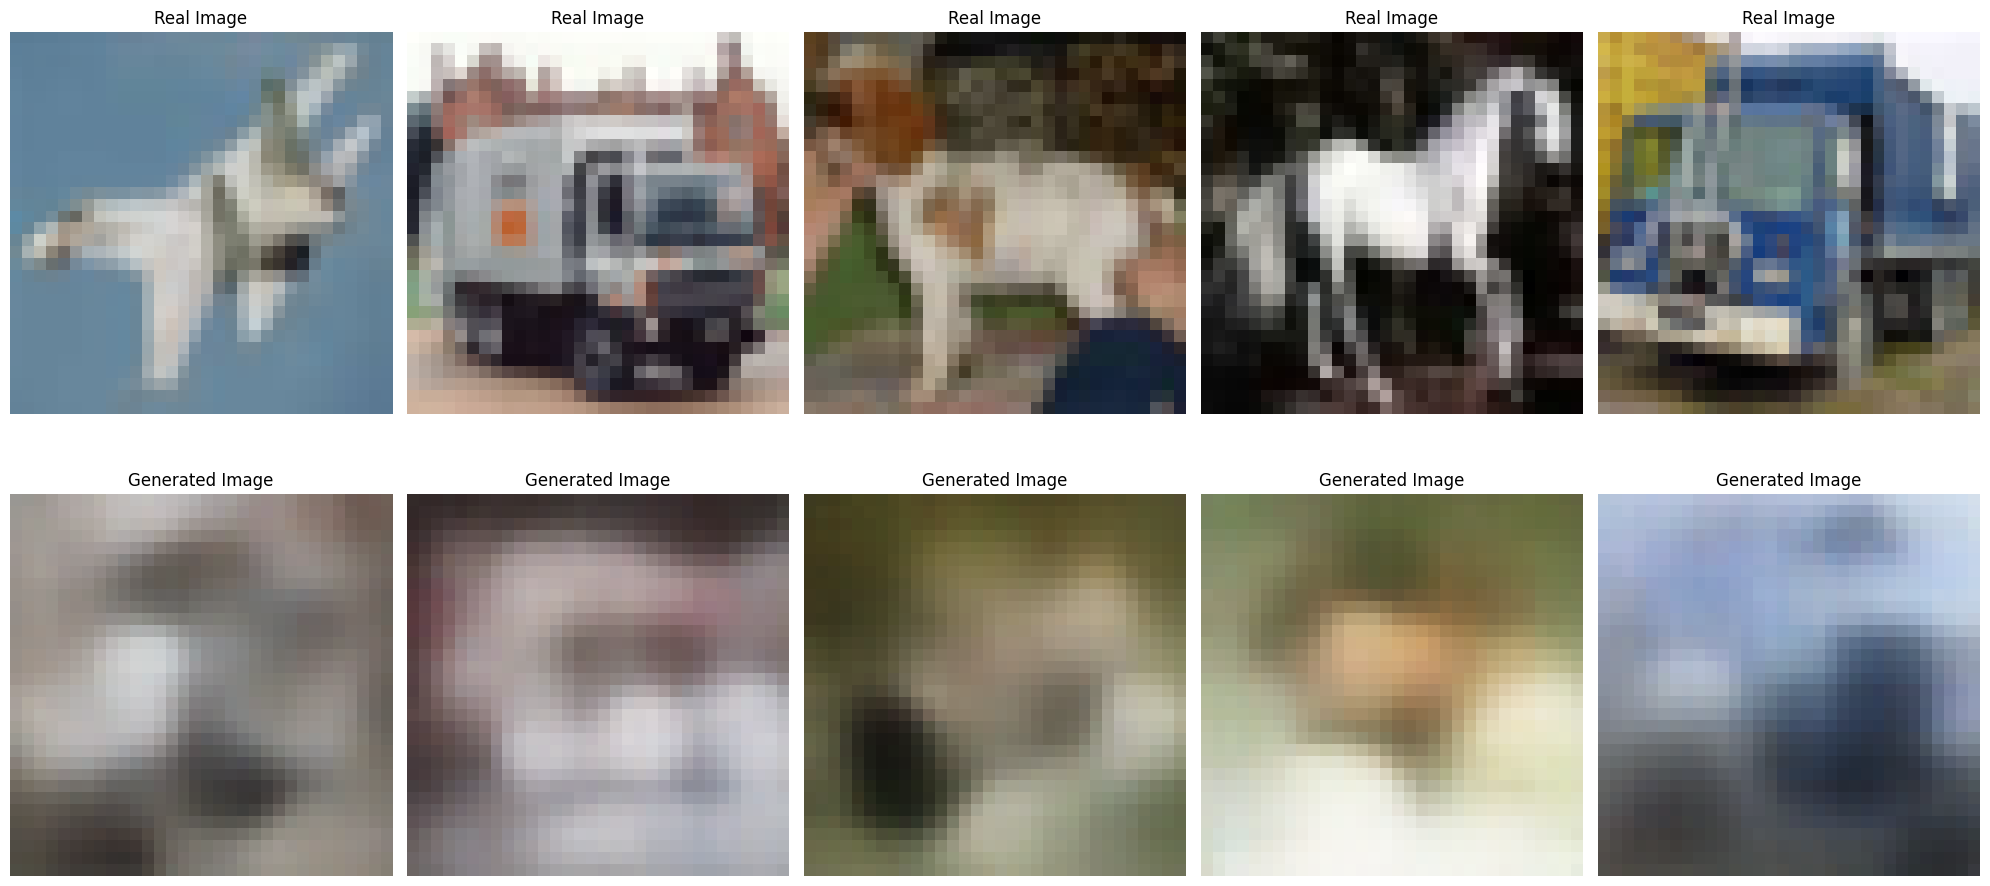

In [30]:
def generate_images_from_latent_vectors(vae,num_images_to_generate):
  random_latent_vectors = np.random.normal(size=(num_images_to_generate, vae.latent_dim))
  generated_images = vae.decoder.predict(random_latent_vectors)
  return generated_images
# Call the function to generate images and assign the result to generated_images in global scope
generated_images = generate_images_from_latent_vectors(vae,20) # This line moved outside the function

def plot_real_and_generated_images(real_images, generated_images,num_images_to_generate):
    plt.figure(figsize=(20, 10))
    for i in range(num_images_to_generate):
        plt.subplot(2,num_images_to_generate,i+1)
        plt.imshow(real_images[i+10])
        plt.title('Real Image')
        plt.axis('off')
    for i in range(num_images_to_generate):
        plt.subplot(2,num_images_to_generate,num_images_to_generate + i + 1)
        plt.imshow(generated_images[i+10])
        plt.title('Generated Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_real_and_generated_images(x_test, generated_images, 5)

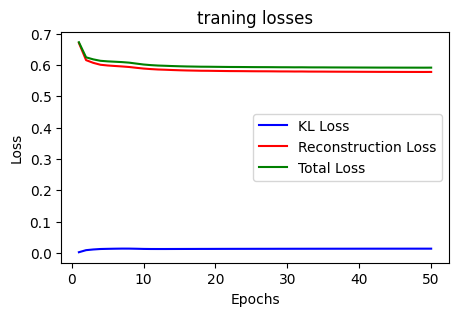

In [32]:
kl_loss = history.history['kl_loss']
reconstruction_loss = history.history['reconstruction_loss']
# The total loss is stored under the key "loss"
total_loss = history.history['loss']
epochs = range(1, len(kl_loss) + 1)
plt.figure(figsize=(5, 3))
plt.plot(epochs, kl_loss, 'b', label='KL Loss')
plt.plot(epochs, reconstruction_loss, 'r', label='Reconstruction Loss')
plt.plot(epochs, total_loss, 'g', label='Total Loss')
plt.title('traning losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()